# <center> Video Anomaly Detection 📽️</center>
## <center>If you find this notebook useful, support with an upvote👍</center>

**Created by Sanskar Hasija**

**Video Anomaly Detection 📽️**

**12 NOVEMBER 2021**


## [1. Imports](#im) ##
## [2. HyperParameters](#hp) ##
## [3. Data Loading and Preprocessing](#data) ##
## [4. DenseNet121 Feature Extractor](#model)  ##
## [5. Training](#train) ##
## [6. Mutliclass AUC Curve](#auc) ##

<a id="im"></a>
# <center>IMPORTING LIBRARIES</center> 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [2]:
print(tf.test.is_built_with_cuda())

tf.config.LogicalDeviceConfiguration()

True


LogicalDeviceConfiguration(memory_limit=None, experimental_priority=None)

<a id="hp"></a>
# <center>HYPERPARAMETRERS AND DIRECTORIES</center>

In [9]:
#importing the dataset to the variables
train_dir = "Train" 
test_dir = "Test"

SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 64
EPOCHS = 1
LR =  0.00003
NUM_CLASSES = 14
CLASS_LABELS = ['Abuse','Arrest','Arson','Assault','Burglary','Explosion','Fighting',"Normal",'RoadAccidents','Robbery','Shooting','Shoplifting','Stealing','Vandalism']

<a id="data"></a>
# <center> DATA LOADING AND PRE-PROCESSING</center>

Creating two different generator for train and test data

In [4]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  preprocessing_function=preprocess_fun
                                 )

In [5]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = SEED
                                                   )
test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = SEED
                                                  )

Found 1266345 images belonging to 14 classes.
Found 111308 images belonging to 14 classes.


## Data distribution (count) among all the classes

### Train data Distribution

In [6]:
fig = px.bar(x = CLASS_LABELS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] , 
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Classes")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

### Test Data Distribution

In [7]:
fig = px.bar(x = CLASS_LABELS,
             y = [list(test_generator.classes).count(i) for i in np.unique(test_generator.classes)] , 
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Classes")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Test Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

<a id="model"></a>
# <center> DenseNet121 Transfer Learning  </center>

In [8]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet121(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(LR), 
                loss='categorical_crossentropy',
                metrics = [tf.keras.metrics.AUC()])
  
    return model

model = define_compile_model()
clear_output()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 densenet121 (Functional)    (None, 2, 2, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              263168    
                                                             

<a id="train"></a>
# <center> Training </center> 

In [9]:
history = model.fit(x = train_generator,validation_data=test_generator,epochs = EPOCHS)

19787/19787 [==============================] - 49052s 2s/step - loss: 1.2456 - auc: 0.9105 - val_loss: 1.7073 - val_auc: 0.8388


<a id="auc"></a>
# <center> Multiclass AUC Curve </center> 

ROC AUC score: 0.839623028580872


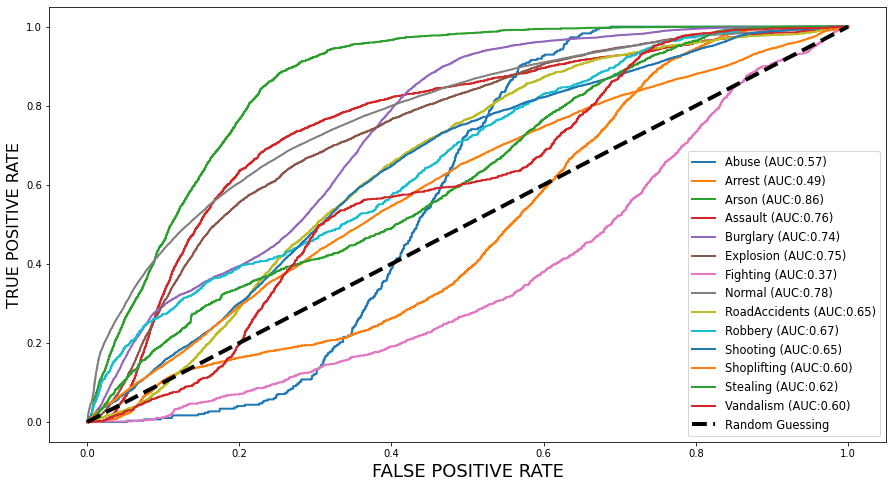

In [10]:
preds = model.predict(test_generator)
y_test = test_generator.classes
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [12]:
import pickle
pickle.dump(model,open("model.pkl","wb"))

INFO:tensorflow:Assets written to: ram://b42f38f6-34d3-4835-af09-5378a6fbfbcd/assets


In [15]:
type(test_datagen)

keras.preprocessing.image.ImageDataGenerator

In [50]:
testt_dir="Train/Fighting"

In [51]:
preprocess_fun1 = tf.keras.applications.densenet.preprocess_input

test_datagen1 = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   preprocessing_function=preprocess_fun
                                  )

In [55]:
test_generator1 = test_datagen1.flow_from_directory(directory = testt_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = SEED
                                                  )

Found 0 images belonging to 0 classes.


In [29]:
model.save("model_1.h5")

In [10]:
from keras.models import load_model
from keras.preprocessing import image
import cv2
mdl=load_model('model_1.h5')
mdl.compile(optimizer=tf.keras.optimizers.SGD(LR), 
                loss='categorical_crossentropy',
                metrics = [tf.keras.metrics.AUC()])
#predicting images
img = tf.keras.preprocessing.image.load_img('Train/Fighting/Fighting002_x264_320.png')
# Load_imagemg=cv2.imread('img.jpg')

img=tf.image.resize(img,(64,64))
# img = cv2.resize(img,(IMG_HEIGHT,IMG_WIDTH),3)

classes=mdl.predict(img)
# print(mdl)


ValueError: in user code:

    File "C:\Users\mukul\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\mukul\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\mukul\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\mukul\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\Users\mukul\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\mukul\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 64, 64, 3), found shape=(32, 64, 3)


In [42]:
from PIL import Image

image = Image.open('img.jpg')
image.show()

In [1]:
from tensorflow.keras.preprocessing import image
#Load an Image

# importing required libraries
import matplotlib.pyplot as plt
import matplotlib.image as img
  
# reading the image
testImage = img.imread('img.jpg')
# plt.imshow(testImage)
img = image.load_img('acci.jpg', target_size=(64, 64)) 


In [4]:
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

In [6]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input
img_preprocessed = preprocess_fun(img_batch)

In [11]:
prediction=mdl.predict(img_preprocessed)

In [12]:
print(prediction)

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
